# A few simple data exercises

Here we will use a subset of a dataset sourced from Kaggle: [https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset](https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset)

It consists of anonymized scraped house listings for the whole U.S. for one point in time during 2024.

In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql


### Helper function definitions

In the next cell we define some functions which will be useful for this exercise.

In [2]:
def load_listings(filen,dtypes_dict={'brokered_by': str,
                                     'status':str,
                                     'price':float,
                                     'bed':float,
                                     'bath':float,
                                     'acre_lot':float,
                                     'street':str,
                                     'city':str,
                                     'state':str,
                                     'zip_code':str,
                                     'house_size':float,
                                     'prev_sold_date':str
                                    }):
    df_in = pd.read_csv(filen,dtype=dtypes_dict)
    df_in['prev_sold_date'] = pd.to_datetime(df_in.prev_sold_date,errors='coerce')
    return df_in



def refresh_sqlite_table_from_df(dbfile,tablename,df):
    conn = sql.connect(dbfile)
    df.to_sql(tablename, conn, if_exists='replace', index=False)
    conn.commit()
    conn.close()

def df_from_sqlite_query(dbfile,query):
    conn = sql.connect(dbfile)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df
    





## Load and peek and the dataset

Notice that this make take a few seconds

In [3]:
%%time

listings_df = load_listings('../data/some_listings.csv')

listings_df

CPU times: total: 1.09 s
Wall time: 1.12 s


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,22505,for_sale,269000.0,NaN,NaN,4.70,148075,Vero Beach,Florida,32966,NaN,2013-12-04
1,67091,sold,112000.0,4.0,1.0,0.22,28055,Neillsville,Wisconsin,54456,1420.0,2022-04-28
2,85045,for_sale,74500.0,NaN,NaN,3.65,1981526,Johnson City,Tennessee,37615,NaN,NaT
3,16829,sold,995000.0,3.0,2.0,0.06,1069629,San Francisco,California,94110,1275.0,2022-04-20
4,16250,for_sale,124900.0,2.0,1.0,0.24,1674940,Garland,Texas,75040,1040.0,1990-05-30
...,...,...,...,...,...,...,...,...,...,...,...,...
499995,22439,sold,611000.0,5.0,4.0,0.25,315753,Newberry,Florida,32669,2982.0,2022-02-04
499996,46248,sold,319900.0,2.0,2.0,0.15,193859,Huntley,Illinois,60142,1579.0,2022-03-17
499997,41784,sold,650000.0,4.0,2.0,0.17,925931,Phoenix,Arizona,85086,2350.0,2022-04-12
499998,96692,for_sale,459000.0,NaN,NaN,1.71,669352,Seneca,South Carolina,29672,NaN,2021-05-13


## Put our dataset into a local SQL database file

This allows us to simulate querying an actual SQL server.

In [4]:
%%time

refresh_sqlite_table_from_df('../data/sql/some_listings.db','listings',listings_df)

CPU times: total: 2.75 s
Wall time: 3.01 s


## Our first SQL query--pull the first 50 observations off the top

In [5]:
query = """SELECT
  *
FROM listings
LIMIT 50
"""



df_from_sqlite_query('../data/sql/some_listings.db',
                     query)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,22505,for_sale,269000.0,NaN,NaN,4.70,148075,Vero Beach,Florida,32966,NaN,2013-12-04 00:00:00
1,67091,sold,112000.0,4.0,1.0,0.22,28055,Neillsville,Wisconsin,54456,1420.0,2022-04-28 00:00:00
2,85045,for_sale,74500.0,NaN,NaN,3.65,1981526,Johnson City,Tennessee,37615,NaN,None
3,16829,sold,995000.0,3.0,2.0,0.06,1069629,San Francisco,California,94110,1275.0,2022-04-20 00:00:00
4,16250,for_sale,124900.0,2.0,1.0,0.24,1674940,Garland,Texas,75040,1040.0,1990-05-30 00:00:00
5,35426,for_sale,151000.0,2.0,1.0,0.26,274329,Leavenworth,Kansas,66048,1058.0,2011-11-14 00:00:00
6,71366,sold,560000.0,4.0,3.0,0.25,1047198,Dallas,Texas,75229,2507.0,2022-02-04 00:00:00
7,30421,for_sale,4000.0,NaN,NaN,0.47,1978243,McCalla,Alabama,35111,NaN,None
8,36481,for_sale,71500.0,NaN,NaN,0.11,793515,Dyersburg,Tennessee,38024,NaN,None
9,47405,for_sale,225000.0,3.0,2.0,0.69,1501717,Midland,Texas,79705,984.0,2017-10-03 00:00:00


## Pandas equivalent

In [6]:
listings_df.iloc[0:50]

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,22505,for_sale,269000.0,NaN,NaN,4.70,148075,Vero Beach,Florida,32966,NaN,2013-12-04
1,67091,sold,112000.0,4.0,1.0,0.22,28055,Neillsville,Wisconsin,54456,1420.0,2022-04-28
2,85045,for_sale,74500.0,NaN,NaN,3.65,1981526,Johnson City,Tennessee,37615,NaN,NaT
3,16829,sold,995000.0,3.0,2.0,0.06,1069629,San Francisco,California,94110,1275.0,2022-04-20
4,16250,for_sale,124900.0,2.0,1.0,0.24,1674940,Garland,Texas,75040,1040.0,1990-05-30
5,35426,for_sale,151000.0,2.0,1.0,0.26,274329,Leavenworth,Kansas,66048,1058.0,2011-11-14
6,71366,sold,560000.0,4.0,3.0,0.25,1047198,Dallas,Texas,75229,2507.0,2022-02-04
7,30421,for_sale,4000.0,NaN,NaN,0.47,1978243,McCalla,Alabama,35111,NaN,NaT
8,36481,for_sale,71500.0,NaN,NaN,0.11,793515,Dyersburg,Tennessee,38024,NaN,NaT
9,47405,for_sale,225000.0,3.0,2.0,0.69,1501717,Midland,Texas,79705,984.0,2017-10-03


## Now, let's pull the 50 most expensive houses

In [7]:
query = """SELECT
  *
FROM listings
ORDER BY
  price DESC
LIMIT 50
"""



df_from_sqlite_query('../data/sql/some_listings.db',
                     query)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,23826,for_sale,2.147484e+09,2.0,2.0,0.12,11355,International,California,None,885.0,None
1,13872,for_sale,5.150000e+08,2.0,2.0,2.59,1658312,San Diego,California,92119,1048.0,2018-04-17 00:00:00
2,43753,for_sale,1.650000e+08,14.0,27.0,4.60,1442774,Los Angeles,California,90024,56500.0,2019-07-02 00:00:00
3,69876,for_sale,1.626270e+08,NaN,NaN,542.09,1391575,Union City,Georgia,30291,NaN,None
4,107980,for_sale,1.500000e+08,NaN,NaN,2.28,591322,Palm Beach,Florida,33480,NaN,None
5,98034,for_sale,1.390000e+08,12.0,18.0,2.08,202619,Los Angeles,California,90077,NaN,2014-01-07 00:00:00
6,75249,for_sale,1.270000e+08,NaN,NaN,32995.00,1517138,Bend,Oregon,97701,NaN,None
7,16829,for_sale,1.090000e+08,3.0,4.0,4.21,904983,Carpinteria,California,93013,2514.0,2002-08-01 00:00:00
8,78932,for_sale,1.000000e+08,7.0,12.0,3600.00,1721324,Ojai,California,93023,25661.0,None
9,70602,for_sale,7.900000e+07,NaN,NaN,1395.00,1902549,Lihue,Hawaii,96766,NaN,None


## 50 most expensive houses, using Pandas

In [8]:
listings_df.sort_values(by='price',ascending=False).iloc[0:50]

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
66617,23826,for_sale,2.147484e+09,2.0,2.0,0.12,11355,International,California,NaN,885.0,NaT
187579,13872,for_sale,5.150000e+08,2.0,2.0,2.59,1658312,San Diego,California,92119,1048.0,2018-04-17
191799,43753,for_sale,1.650000e+08,14.0,27.0,4.60,1442774,Los Angeles,California,90024,56500.0,2019-07-02
290103,69876,for_sale,1.626270e+08,NaN,NaN,542.09,1391575,Union City,Georgia,30291,NaN,NaT
148520,107980,for_sale,1.500000e+08,NaN,NaN,2.28,591322,Palm Beach,Florida,33480,NaN,NaT
118910,98034,for_sale,1.390000e+08,12.0,18.0,2.08,202619,Los Angeles,California,90077,NaN,2014-01-07
308832,75249,for_sale,1.270000e+08,NaN,NaN,32995.00,1517138,Bend,Oregon,97701,NaN,NaT
77310,16829,for_sale,1.090000e+08,3.0,4.0,4.21,904983,Carpinteria,California,93013,2514.0,2002-08-01
24024,78932,for_sale,1.000000e+08,7.0,12.0,3600.00,1721324,Ojai,California,93023,25661.0,NaT
142474,70602,for_sale,7.900000e+07,NaN,NaN,1395.00,1902549,Lihue,Hawaii,96766,NaN,NaT


## Which states have better data quality for house size?

We have to multiply the numerator of our "fraction" below by 1.0, because otherwise SQLite will treat the quotient of two integers as an integer and round down.

In [9]:

query = """SELECT
  state,
  (1.0*COUNT(house_size))/COUNT(*) as fraction_of_house_size_observed,
  COUNT(*) as total_listings
FROM listings
GROUP BY
  state
ORDER BY
  state
"""



df_from_sqlite_query('../data/sql/some_listings.db',
                     query)

,state,fraction_of_house_size_observed,total_listings
0,None,1.000000,3
1,Alabama,0.628282,7694
2,Alaska,0.378136,558
3,Arizona,0.784454,16377
4,Arkansas,0.542935,5159
5,California,0.868578,51034
6,Colorado,0.779492,7324
7,Connecticut,0.876830,3142
8,Delaware,0.863963,1948
9,District of Columbia,0.972863,1474


## Data coverage for house size by state, with Pandas

In [10]:
summary_df = listings_df[['state','house_size','status']].groupby('state').count().reset_index()
summary_df['house_size'] /= summary_df['status']
summary_df.columns = ['state','fraction_of_house_size_observed','total_listings']
summary_df

,state,fraction_of_house_size_observed,total_listings
0,Alabama,0.628282,7694
1,Alaska,0.378136,558
2,Arizona,0.784454,16377
3,Arkansas,0.542935,5159
4,California,0.868578,51034
5,Colorado,0.779492,7324
6,Connecticut,0.876830,3142
7,Delaware,0.863963,1948
8,District of Columbia,0.972863,1474
9,Florida,0.754181,55964


## How many brokers in each state?

In [11]:

query = """SELECT
  state,
  COUNT(DISTINCT brokered_by) as num_brokers
FROM listings
GROUP BY
  state
ORDER BY
  state
"""



df_from_sqlite_query('../data/sql/some_listings.db',
                     query)

,state,num_brokers
0,None,2
1,Alabama,1290
2,Alaska,130
3,Arizona,1639
4,Arkansas,791
5,California,9528
6,Colorado,1477
7,Connecticut,664
8,Delaware,222
9,District of Columbia,235


## Count brokers with Pandas

In [12]:
listings_df[['state','brokered_by']].groupby('state').nunique().reset_index()

,state,brokered_by
0,Alabama,1290
1,Alaska,130
2,Arizona,1639
3,Arkansas,791
4,California,9528
5,Colorado,1477
6,Connecticut,664
7,Delaware,222
8,District of Columbia,235
9,Florida,9128


## Average house price

Because SQLite does not have a built-in standard deviation function, below we use a subquery to compute the means by state so that we can calculate standard deviations in the final step.

Depending on the version of SQL you are using, there may be other more efficient ways to do this. Also, many versions of SQL have a built-in standard deviation function.

In [13]:
query = """SELECT
  a.state as state,
  mean_price,
  SQRT(SUM(POWER(price - mean_price,2))/num_price_obs) as stdev_price,
  (1.0*num_price_obs)/COUNT(*) as fraction_of_price_observed,
  COUNT(*) as total_listings
FROM listings as a
LEFT JOIN (SELECT
  state,
  AVG(price) as mean_price,
  COUNT(price) as num_price_obs
FROM listings
GROUP BY
  state) as b
ON a.state = b.state
GROUP BY 
  a.state
ORDER BY
  a.state
"""

df_from_sqlite_query('../data/sql/some_listings.db',
                     query)

,state,mean_price,stdev_price,fraction_of_price_observed,total_listings
0,None,NaN,NaN,NaN,3
1,Alabama,3.087028e+05,5.718917e+05,0.999610,7694
2,Alaska,2.869199e+05,5.312561e+05,1.000000,558
3,Arizona,4.927771e+05,7.984268e+05,0.998962,16377
4,Arkansas,2.688610e+05,4.746488e+05,1.000000,5159
5,California,1.066698e+06,9.994679e+06,0.999882,51034
6,Colorado,8.050062e+05,1.725220e+06,0.999590,7324
7,Connecticut,6.487919e+05,1.186684e+06,1.000000,3142
8,Delaware,4.354121e+05,6.159568e+05,0.998973,1948
9,District of Columbia,9.092969e+05,1.039117e+06,1.000000,1474


## Average house price by state, with Pandas

In [14]:
listings_df[['state','price','status']].groupby('state').agg({'price':['mean','std'],
                                                              'status':'count'}).reset_index()

state         price               status
                                  mean           std  count
0                Alabama  3.087028e+05  5.719288e+05   7694
1                 Alaska  2.869199e+05  5.317327e+05    558
2                Arizona  4.927771e+05  7.984512e+05  16377
3               Arkansas  2.688610e+05  4.746949e+05   5159
4             California  1.066698e+06  9.994777e+06  51034
5               Colorado  8.050062e+05  1.725338e+06   7324
6            Connecticut  6.487919e+05  1.186873e+06   3142
7               Delaware  4.354121e+05  6.161151e+05   1948
8   District of Columbia  9.092969e+05  1.039470e+06   1474
9                Florida  5.458396e+05  1.475872e+06  55964
10               Georgia  3.917701e+05  1.288598e+06  18429
11                  Guam  6.054621e+05  7.111290e+05    128
12                Hawaii  1.277504e+06  3.049854e+06   1616
13                 Idaho  6.434547e+05  8.013936e+05   3812
14              Illinois  3.408170e+05  4.303169e+05  19151
15               Indiana  2.949754e+05  5.169669e+05   4302
16                  Iowa  2.486586e+05  2.894921e+05   5102
17                Kansas  2.891076e+05  3.872551e+05   3267
18              Kentucky  2.647270e+05  3.711501e+05   5986
19             Louisiana  2.828909e+05  4.356616e+05   5800
20                 Maine  3.238336e+05  5.194133e+05   1135
21              Maryland  4.541498e+05  4.614690e+05  10301
22         Massachusetts  7.289933e+05  1.008987e+06   8542
23              Michigan  2.699088e+05  4.283006e+05   9417
24             Minnesota  3.672833e+05  4.018425e+05   9766
25           Mississippi  2.724184e+05  5.069288e+05   3617
26              Missouri  2.897301e+05  4.770957e+05  10177
27               Montana  7.882648e+05  1.839878e+06   2229
28              Nebraska  2.866169e+05  2.869632e+05   1435
29                Nevada  6.573667e+05  1.022990e+06   3341
30         New Hampshire  5.176055e+05  9.752719e+05    829
31            New Jersey  5.775598e+05  7.820796e+05  10939
32            New Mexico  3.341020e+05  6.256938e+05   4712
33              New York  9.306825e+05  2.315661e+06  23037
34        North Carolina  3.352133e+05  4.863163e+05  19258
35          North Dakota  2.612472e+05  3.974683e+05    976
36                  Ohio  2.458472e+05  3.510470e+05  13328
37              Oklahoma  2.669646e+05  3.243214e+05   8163
38                Oregon  5.954824e+05  1.714993e+06   7109
39          Pennsylvania  3.351785e+05  5.281018e+05  17572
40           Puerto Rico  6.322519e+05  1.517940e+06    705
41          Rhode Island  4.766335e+05  4.658953e+05   1810
42        South Carolina  3.942509e+05  6.185069e+05   9530
43          South Dakota  3.880121e+05  7.341680e+05   1084
44             Tennessee  3.735990e+05  6.506442e+05   9205
45                 Texas  4.413513e+05  7.527718e+05  46717
46                  Utah  9.160579e+05  1.984082e+06   3277
47               Vermont  4.362904e+05  6.935468e+05    549
48        Virgin Islands  9.943825e+05  2.864070e+06    196
49              Virginia  4.631352e+05  6.180535e+05  15631
50            Washington  6.696977e+05  8.589114e+05  13922
51         West Virginia  2.305048e+05  3.220738e+05   2725
52             Wisconsin  2.765553e+05  3.788516e+05   9591
53               Wyoming  6.286307e+05  2.142113e+06    905

## Histogram of house prices

Notice that we can't see much, because the outliers drag out the $x$-axis range

<Axes: >

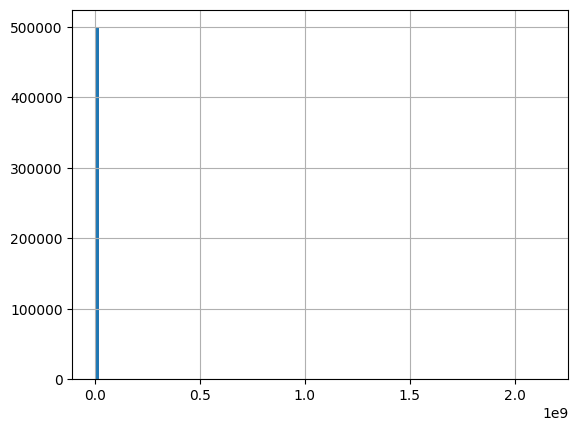

In [15]:
listings_df.price.hist(bins=100)

### Restricting the $x$-axis range

<Axes: >

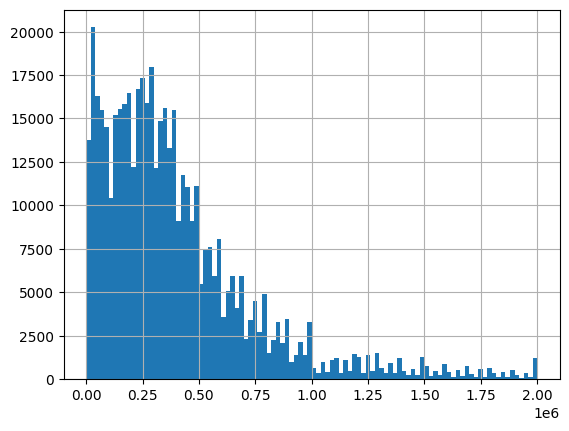

In [16]:
listings_df.price.hist(bins=100,range=[0,2000000])

### Plotting log house price

Notice this looks like a much tidier distribution.

We will have to exclude points where the price is zero, because $\lim\limits_{x\to 0} \log x = -\infty$

C:\Users\MDelventhal\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

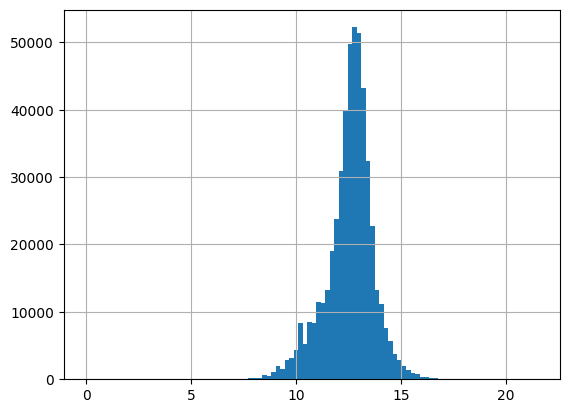

In [17]:
listings_df['log_price'] = np.log(listings_df['price'])
listings_df.loc[listings_df.price > 0,'log_price'].hist(bins=100)

## Adding log price to our summarizing query

Notice that the standard deviations of log price are all significantly less than the means--in contrast to the standard deviations of the level of price, which were all bigger than the mean!

This is because the un-logged prices are a very skewed (i.e. asymmetrical) distribution, and the outliers inflate the standard deviation. The distribution of log price, on the other hand, is symmetrical, and the outliers are "tamed" by the log transformation.

In [18]:
query = """SELECT
  a.state as state,
  mean_price,
  SQRT(SUM(POWER(price - mean_price,2))/num_price_obs) as stdev_price,
  (1.0*num_price_obs)/COUNT(*) as fraction_of_price_observed,
  mean_log_price,
  SQRT(SUM(POWER(LN(price) - mean_log_price,2))/num_log_price_obs) as stdev_log_price,
  (1.0*num_log_price_obs)/COUNT(*) as fraction_of_log_price_observed,
  COUNT(*) as total_listings
FROM listings as a
LEFT JOIN (SELECT
  state,
  AVG(price) as mean_price,
  AVG(LN(price)) as mean_log_price,
  COUNT(price) as num_price_obs,
  SUM(CASE WHEN price > 0 THEN 1 ELSE 0 END) as num_log_price_obs
FROM listings
GROUP BY
  state) as b
ON a.state = b.state
GROUP BY 
  a.state
ORDER BY
  a.state
"""

df_from_sqlite_query('../data/sql/some_listings.db',
                     query)

,state,mean_price,stdev_price,fraction_of_price_observed,mean_log_price,stdev_log_price,fraction_of_log_price_observed,total_listings
0,None,NaN,NaN,NaN,NaN,NaN,NaN,3
1,Alabama,3.087028e+05,5.718917e+05,0.999610,12.012806,1.191679,0.999610,7694
2,Alaska,2.869199e+05,5.312561e+05,1.000000,11.811461,1.270901,1.000000,558
3,Arizona,4.927771e+05,7.984268e+05,0.998962,12.622859,1.101605,0.998840,16377
4,Arkansas,2.688610e+05,4.746488e+05,1.000000,11.595314,1.571101,1.000000,5159
5,California,1.066698e+06,9.994679e+06,0.999882,13.322190,1.066419,0.999843,51034
6,Colorado,8.050062e+05,1.725220e+06,0.999590,13.019941,1.101357,0.999181,7324
7,Connecticut,6.487919e+05,1.186684e+06,1.000000,12.856464,0.925194,1.000000,3142
8,Delaware,4.354121e+05,6.159568e+05,0.998973,12.724829,0.691249,0.998973,1948
9,District of Columbia,9.092969e+05,1.039117e+06,1.000000,13.425355,0.732674,1.000000,1474


## Do the same with Pandas

Notice that Pandas does not automatically exclude the non-finite values from the mean calculation.

In [19]:
listings_df[['state','price','log_price','status']].groupby('state').agg({'price':['mean','std'],
                                                                          'log_price':['mean','std'],
                                                                          'status':'count'}).reset_index()

state         price                log_price            \
                                  mean           std       mean       std   
0                Alabama  3.087028e+05  5.719288e+05  12.012806  1.191757   
1                 Alaska  2.869199e+05  5.317327e+05  11.811461  1.272042   
2                Arizona  4.927771e+05  7.984512e+05       -inf       NaN   
3               Arkansas  2.688610e+05  4.746949e+05  11.595314  1.571253   
4             California  1.066698e+06  9.994777e+06       -inf       NaN   
5               Colorado  8.050062e+05  1.725338e+06       -inf       NaN   
6            Connecticut  6.487919e+05  1.186873e+06  12.856464  0.925342   
7               Delaware  4.354121e+05  6.161151e+05  12.724829  0.691427   
8   District of Columbia  9.092969e+05  1.039470e+06  13.425355  0.732922   
9                Florida  5.458396e+05  1.475872e+06       -inf       NaN   
10               Georgia  3.917701e+05  1.288598e+06  12.429804  1.011810   
11                  Guam  6.054621e+05  7.111290e+05  12.840314  0.975114   
12                Hawaii  1.277504e+06  3.049854e+06  13.167085  1.431290   
13                 Idaho  6.434547e+05  8.013936e+05       -inf       NaN   
14              Illinois  3.408170e+05  4.303169e+05  12.289654  1.020355   
15               Indiana  2.949754e+05  5.169669e+05  12.075827  1.114262   
16                  Iowa  2.486586e+05  2.894921e+05  12.041917  1.045629   
17                Kansas  2.891076e+05  3.872551e+05  12.099434  1.067526   
18              Kentucky  2.647270e+05  3.711501e+05  12.030758  1.056072   
19             Louisiana  2.828909e+05  4.356616e+05  12.060208  1.077375   
20                 Maine  3.238336e+05  5.194133e+05  12.032689  1.151022   
21              Maryland  4.541498e+05  4.614690e+05  12.723071  0.839605   
22         Massachusetts  7.289933e+05  1.008987e+06  13.153856  0.798102   
23              Michigan  2.699088e+05  4.283006e+05  11.872285  1.220589   
24             Minnesota  3.672833e+05  4.018425e+05  12.469868  0.934563   
25           Mississippi  2.724184e+05  5.069288e+05  11.867146  1.198393   
26              Missouri  2.897301e+05  4.770957e+05  12.071900  1.086761   
27               Montana  7.882648e+05  1.839878e+06  12.760347  1.462606   
28              Nebraska  2.866169e+05  2.869632e+05  12.192757  0.965717   
29                Nevada  6.573667e+05  1.022990e+06       -inf       NaN   
30         New Hampshire  5.176055e+05  9.752719e+05  12.582759  1.113748   
31            New Jersey  5.775598e+05  7.820796e+05       -inf       NaN   
32            New Mexico  3.341020e+05  6.256938e+05  12.047766  1.324586   
33              New York  9.306825e+05  2.315661e+06       -inf       NaN   
34        North Carolina  3.352133e+05  4.863163e+05       -inf       NaN   
35          North Dakota  2.612472e+05  3.974683e+05  11.952888  1.144407   
36                  Ohio  2.458472e+05  3.510470e+05       -inf       NaN   
37              Oklahoma  2.669646e+05  3.243214e+05       -inf       NaN   
38                Oregon  5.954824e+05  1.714993e+06  12.950583  0.842950   
39          Pennsylvania  3.351785e+05  5.281018e+05  12.294884  0.972336   
40           Puerto Rico  6.322519e+05  1.517940e+06  12.430384  1.197995   
41          Rhode Island  4.766335e+05  4.658953e+05  12.855066  0.614930   
42        South Carolina  3.942509e+05  6.185069e+05  12.380613  1.079011   
43          South Dakota  3.880121e+05  7.341680e+05  12.177430  1.208048   
44             Tennessee  3.735990e+05  6.506442e+05  12.138712  1.283544   
45                 Texas  4.413513e+05  7.527718e+05       -inf       NaN   
46                  Utah  9.160579e+05  1.984082e+06  13.210874  0.964762   
47               Vermont  4.362904e+05  6.935468e+05  12.390864  1.088841   
48        Virgin Islands  9.943825e+05  2.864070e+06  12.605238  1.374736   
49              Virginia  4.631352e+05  6.180535e+05  12.630716  1.012967   
50            W

## Correlation between house size and price

Below we'll calculate the simple correlation (Pearson's correlation coefficient), and make a scatterplot.

<Axes: xlabel='log_house_size', ylabel='log_price'>

,log_house_size,log_price
log_house_size,1.000000,0.537164
log_price,0.537164,1.000000


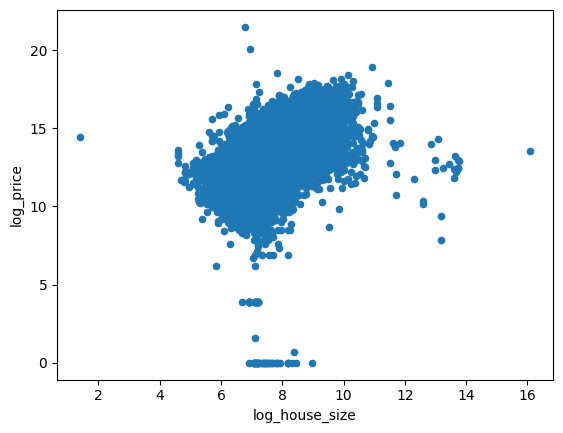

In [20]:
listings_df['log_house_size'] = np.log(listings_df.house_size)

display(listings_df.plot.scatter(x='log_house_size',y='log_price'))

display(listings_df[['log_house_size','log_price']].corr())


## Focus on one state

Now the correlation is higher. Why do you think that is?

Modify the code below to try this for other state, too!

<Axes: xlabel='log_house_size', ylabel='log_price'>

,log_house_size,log_price
log_house_size,1.000000,0.722793
log_price,0.722793,1.000000


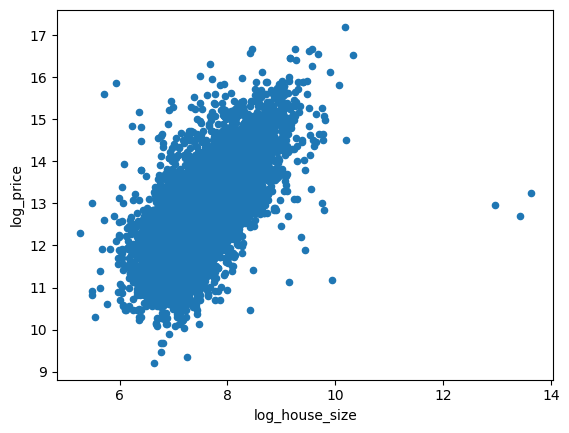

In [21]:

display(listings_df.loc[listings_df.state == 'Texas'].plot.scatter(x='log_house_size',y='log_price'))

display(listings_df.loc[listings_df.state == 'Texas',['log_house_size','log_price']].corr())

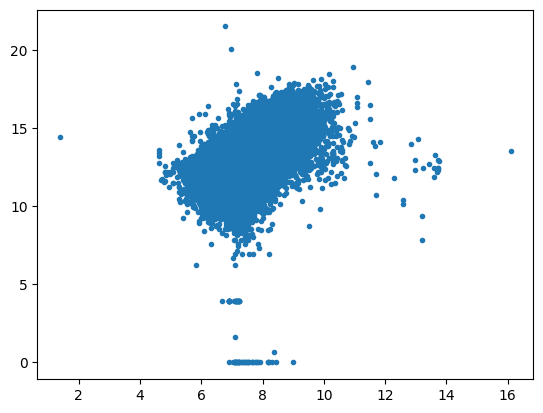

In [22]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(listings_df.log_house_size,listings_df.log_price,'.')
plt.show()



## Some more exercises

  1. Calculate price per square foot, and summarize by state.
  2. Construct a regression or other model to predict either house price, or price per square foot, from observable characteristics.

#### Extra credit:
  - Validate your model using cross-validation.
  - Save the dataset as a Parquet file and compare file size + loading time.
  - Commit your changes locally with Git.
  - Create a forked version of the repo on your own Github account, and push your updates.